In [8]:
#SETUP
from __future__ import print_function
import pandas as pd
from pandas import DataFrame, read_csv,to_timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil

def parseMeterFile(sourceName):
    saveName = sourceName[:-4] #remove .txt
    index = saveName.find("LD")
    index2 = saveName.find("_")
    LD = saveName[index+2:index2]
    with open(sourceName,'r') as txtfile:
        txtlines = txtfile.readlines()[1:]
    vec = []
    for i in txtlines:
        start = i.find('\t')
        if i[start+1]=='-':
            a=1
        else:
            a=0
        val = 1000*float(i[start:start+6])*10**float(i[start+8+a:-3])
        vec.append(val)
    return LD,vec,saveName

def parseSummaryFile(summaryFile):
    #get LD #
    index = summaryFile.find("LD")
    index2 = summaryFile.find("_")
    LD = summaryFile[index+2:index2]
    summaryText = open(summaryFile,'r')
    lineNum = 0
    #Find the "***" delimeter so we know how many data points there are
    for line in summaryText:
        if line.find("***")>-1:
            rowsInSummaryFile = lineNum
            break
        lineNum += 1

    summaryData = pd.read_csv(summaryFile,header=None,nrows=rowsInSummaryFile)
    powerLvls = []
    lightOutputs = []
    for i in summaryData[0]:
        powerLvls.append(i)
    for i in summaryData[1]:
        lightOutputs.append(i)

    return LD,powerLvls,lightOutputs

def getPeaks(vec):
    #################################
    threshold = max(vec[:50])*4 ##
    #################################
    j=len(vec)-1
    indices = []
    vals = []
    while (j>1):
        if vec[j-10] - vec[j-80]<.02 and (vec[j]-vec[j-10])<(threshold*-1):
            indices.append(j-175)
            vals.append(vec[j-175])
            j-=500
        j-=1
    return indices,vals,threshold

def getCalibration(desired,xVec,yVec):
    loop = 0
    for i in yVec:
        if i>desired:
            slope = (yVec[loop]-yVec[loop-1])/(xVec[loop]-xVec[loop-1])
            b = yVec[loop]-xVec[loop]*slope
            return int(round((desired-b)/slope))
        loop+=1

def plotRawGraph(vec,_peakIndices,_peakVals,LD):
    plt.subplot(2,1,1)
    # plt.scatter(range(len(vec)),vec)
    plt.plot(vec)
    plt.scatter(_peakIndices,_peakVals,color='red',s=45)


    title = "LD{} Raw Power Meter Data".format(LD)
    ylabel = "Power (mW)"
    xlabel = 'Sample #'
    plt.title(title,fontsize=20)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.ylim(0,10)
    plt.xlim(0,22000)

def getCalCoords(_peakVals):
    lightOut = _peakVals[::-1] #reverse the order of the peak values since we were getting them from righ to left
    softVals = []
    for i in range(70,1023,50):
        softVals.append(i)
    trimmedSoftVals = softVals[:len(lightOut)]
    return trimmedSoftVals,lightOut

def plotCalibrationCurve(calX,calY,wantedLevel,LD):
    fig = plt.gcf()
    ax1 = fig.add_subplot(212)
    fig.subplots_adjust(bottom=0.2)
    ax1.set_ylim(0,10)
    ax1.set_xlim(0,1050)
    #http://stackoverflow.com/questions/31803817/how-to-add-second-x-axis-at-the-bottom-of-the-first-one-in-matplotlib
    ax2 = ax1.twiny()
    new_tick_locations = np.array(ax1.get_xticks())/1023.0*4.2
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(np.round(new_tick_locations,1))
    ax2.set_xlim(np.array(ax1.get_xlim())/1023.0*4.2)
    ax2.set_xlabel("Photocell Voltage (V)")
    # Move twinned axis ticks and label from top to bottom
    ax2.xaxis.set_ticks_position("bottom")
    ax2.xaxis.set_label_position("bottom")
    # Offset the twin axis below the host
    ax2.spines["bottom"].set_position(("axes", -0.15))


    calibration =  getCalibration(wantedLevel,calX,calY) #get calibrated value
    ax1.scatter(calibration,wantedLevel,marker='D',color="red",s=100) #plot calibrated value
    ax1.scatter(calX,calY,s=45) #plot points
    ax1.plot(calX,calY,'--')    #connect points with dashed line
    ax1.set_title("LD{} Characterization Curve".format(LD),fontsize=20)
    ylabel = "Power (mW)"
    ax1.set_ylabel(ylabel)
    ax1.set_xlabel("powerLevel variable")
    plt.figtext(.5,0,
                "For {} mW the calibration value is {}".format(wantedLevel,calibration),
                fontsize=30,
                ha='center',
                va='bottom')

def saveGraphs(_sourceName,_saveName,bokehGraph):
    # save graphs to local directory
    if not os.path.exists('Calibrations/{}'.format(_saveName)):
        os.makedirs('Calibrations/{}'.format(_saveName))
    plt.savefig("Calibrations/{0}/{0}_graph.png".format(_saveName),bbox_inches='tight')
    plt.savefig("Calibrations/Graphs/{0}_graph.png".format(_saveName),bbox_inches='tight')
    shutil.copy(_sourceName,'Calibrations/{}'.format(_saveName)) #put a copy of the .txt log file in the local folder

def saveSummary(_saveName,_wantedLevel,_trimmedSoftVals,_lightOut,LD):
    ######### Write summary to file###################
    target = open("{0}_{1}mWsummary.txt".format(_saveName,str(_wantedLevel)), 'w')
    for i in range(len(_trimmedSoftVals)):
        target.write("{},{}\n".format(_trimmedSoftVals[i],_lightOut[i]))
    waveform = np.linspace(_wantedLevel,0,num=100)
    vals = [getCalibration(i,_trimmedSoftVals,_lightOut) for i in waveform ]
    target.write("***\n")
    target.write("LD{} {}mW\n".format(LD,_wantedLevel))
    for i in range(len(vals)):
        target.write("{}".format(vals[i]))
        #if i != 0:
        if not((i+1)%5):
            target.write("\n")
        else:
            target.write(",")
    powerTable = range(int(_wantedLevel*10),-1,-1)
    vals = [getCalibration(i/10.0,_trimmedSoftVals,_lightOut) for i in powerTable ]
    target.write("\n")
    for i in range(len(vals)):
    #     print powerTable[i]/10.0,vals[i]
        target.write("{},{}\n".format(powerTable[i]/10.0,vals[i]))
    target.close()

def fitLine2Graph(_trimmedSoftVals,_lightOut):
    coefficients = np.polyfit(_trimmedSoftVals,_lightOut,5)
    f = np.poly1d(coefficients)
    plt.plot(_trimmedSoftVals,f(_trimmedSoftVals),'r')
    print (coefficients)

def showCalVal(showVal):
    print ("For {} mW the calibration value is {}".format(showVal,getCalibration(showVal,trimmedInputs,lightout)))

def getCalVector(wantedLevel,LD,trimmedInputs,lightout):
	waveform = np.linspace(wantedLevel,0,num=100)
	vals = [getCalibration(i,trimmedInputs,lightout) for i in waveform ]

	for i in range(len(vals)):
		print (vals[i],end="")
		if not((i+1)%5):
			print ("")
		else:
			print (",",end="")

def combineGraphs(_ADClevels,laser1vals,laser2vals,wantedLevel):
    fig = plt.gcf()
    ax1 = fig.add_subplot(212)
    fig.subplots_adjust(bottom=0.2)
    ax1.set_ylim(0,10)
    ax1.set_xlim(0,1050)
    #http://stackoverflow.com/questions/31803817/how-to-add-second-x-axis-at-the-bottom-of-the-first-one-in-matplotlib
    ax2 = ax1.twiny()
    new_tick_locations = np.array(ax1.get_xticks())/1023.0*1.1
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(np.round(new_tick_locations,1))
    ax2.set_xlim(np.array(ax1.get_xlim())/1023.0*1.1)
    ax2.set_xlabel("Photodiode Voltage (V)")
    # Move twinned axis ticks and label from top to bottom
    ax2.xaxis.set_ticks_position("bottom")
    ax2.xaxis.set_label_position("bottom")
    # Offset the twin axis below the host
    ax2.spines["bottom"].set_position(("axes", -0.15))


    cal1 =  getCalibration(wantedLevel,_ADClevels,laser1vals) #get calibrated value
    cal2 =  getCalibration(wantedLevel,_ADClevels,laser2vals) #get calibrated value

    ax1.scatter(cal1,wantedLevel,marker='D',color="red",s=100) #plot calibrated value
    ax1.scatter(_ADClevels,laser1vals,s=45) #plot points
    ax1.plot(_ADClevels,laser1vals,'--')    #connect points with dashed line
    ax1.scatter(cal2,wantedLevel,marker='D',color="red",s=100) #plot calibrated value
    ax1.scatter(_ADClevels,laser2vals,s=45) #plot points
    ax1.plot(_ADClevels,laser2vals,'--')    #connect points with dashed line
    # ax1.set_title("LD{} Characterization Curve".format(LD),fontsize=20)
    # ylabel = "Power (mW)"
    # ax1.set_ylabel(ylabel)
    # ax1.set_xlabel("powerLevel variable")
    plt.figtext(.5,0,
                "For {} mW the calibration values are {} and {}".format(wantedLevel,cal1,cal2),
                fontsize=30,
                ha='center',
                va='bottom')


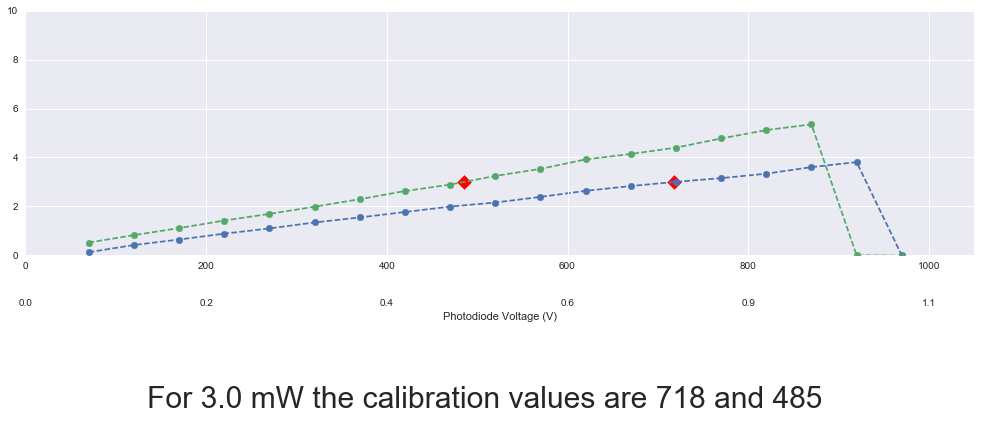

In [9]:

sourceName = 'diode1.txt'
wantedLevel = 3.0
showGraph = True

LD,measuredPowers,saveName = parseMeterFile('diode1.txt')
peakIndices,peakVals,threshold = getPeaks(measuredPowers)
trimmedInputs,lightout1 = getCalCoords(peakVals)
LD,measuredPowers,saveName = parseMeterFile('diode2.txt')
peakIndices,peakVals,threshold = getPeaks(measuredPowers)
trimmedInputs,lightout2 = getCalCoords(peakVals)
plt.figure(figsize=(17,11))
combineGraphs(trimmedInputs,lightout1,lightout2,wantedLevel)

plt.show()
# if showGraph>0:
# 	fig = plt.gcf()
# 	fig.subplots_adjust(hspace=0.3) #add space between subplots
# 	plt.show()

# sourceName = 'diode2.txt'
# wantedLevel = 3.0
# showGraph = True

# LD,measuredPowers,saveName = parseMeterFile(sourceName)
# peakIndices,peakVals,threshold = getPeaks(measuredPowers)
# plt.figure(figsize=(17,11))
# plotRawGraph(measuredPowers,peakIndices,peakVals,LD) #subplot 1
# trimmedInputs,lightout = getCalCoords(peakVals)
# plotCalibrationCurve(trimmedInputs,lightout,wantedLevel,LD) #subplot 2

# if showGraph>0:
# 	fig = plt.gcf()
# 	fig.subplots_adjust(hspace=0.3) #add space between subplots
# 	plt.show()

# # getCalVector(wantedLevel,LD,trimmedInputs,lightout)
# # saveSummary(saveName,wantedLevel,trimmedInputs,lightout,LD)
